In [31]:
import cv2
import numpy as np
import numpy as np
import argparse
import cv2
from commonfunctions import *
import math    

from utlis import *
import functools

In [32]:
%%capture
%run  preprocessing.ipynb

In [33]:
def count_rows(horizontal_lines_img, img, showTrace):
    lines = cv2.HoughLinesP(horizontal_lines_img,rho =5,theta = 1*np.pi/180,threshold = 50,minLineLength = 200,maxLineGap = 50)
    N = lines.shape[0]
    h_lines  = []

    for i in range(N):
        if lines[i][0][1] == lines[i][0][3]:
            x1 = lines[i][0][0]
            y1 = lines[i][0][1]    
            x2 = lines[i][0][2]
            y2 = lines[i][0][3]    
            h_lines.append((x1,y1,x2,y2))

    def sort_horizantal_lines(br_a, br_b):
        return br_a[1] - br_b[1]

    sorted_lines = sorted(h_lines, key=functools.cmp_to_key(sort_horizantal_lines))

    def filter_sorted_lines(array):
        length = len(array)-1
        i=0
        while i<length:
            if abs(array[i][1]-array[i+1][1])<= 10:
                array.pop(i)
                length = length-1
                i=i-1
            i=i+1        

    result = filter_sorted_lines(sorted_lines)

    if(showTrace):
        print("count rows", len(sorted_lines))

        img2 = cv2.merge((img,img,img))

        for i in range(len(sorted_lines)):
            x1 = lines[i][0][0]
            y1 = lines[i][0][1]    
            x2 = lines[i][0][2]
            y2 = lines[i][0][3]    
            cv2.line(img2,(x1,y1),(x2,y2),(0,255,0),2)

        plt.figure(),plt.imshow(img2),plt.title('Hough Lines'),plt.axis('off')
        plt.show()

    return len(sorted_lines)-1


In [34]:
def box_extraction(image, showTrace):
    img = image.copy()
    (thresh, img_bin) = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)  # Thresholding the image
    img_bin = 255-img_bin  
    kernel_length = np.array(img).shape[1]//40
    
    verticle_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_length))
    hori_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_length, 1))

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    
    img_temp1 = cv2.erode(img_bin, verticle_kernel, iterations=3)
    verticle_lines_img = cv2.dilate(img_temp1, verticle_kernel, iterations=3)
   
    img_temp2 = cv2.erode(img_bin, hori_kernel, iterations=3)
    horizontal_lines_img = cv2.dilate(img_temp2, hori_kernel, iterations=3)

    contours, hierarchy = cv2.findContours(horizontal_lines_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # num_rows=3 # comment this line when detect number of rows
    num_rows=count_rows(horizontal_lines_img, img,showTrace) 

    # Weighting parameters, this will decide the quantity of an image to be added to make a new image.
    alpha = 0.5
    beta = 1.0 - alpha
    # This function helps to add two image with specific weight parameter to get a third image as summation of two image.
    img_final_bin = cv2.addWeighted(verticle_lines_img, alpha, horizontal_lines_img, beta, 0.0)
    

    img_final_bin = cv2.erode(~img_final_bin, kernel, iterations=2)
    (thresh, img_final_bin) = cv2.threshold(img_final_bin, 128, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    
    # to get the countours clear of the image
    kernel_two = np.ones((7, 7))
    dilatedImg = cv2.dilate(img_final_bin, kernel_two, iterations=3)
    img_final_bin = cv2.erode(dilatedImg, kernel_two, iterations=1)

    # cv2.imwrite("img_final_bin.jpg",img_final_bin)

    # Find contours for image, which will detect all the boxes
    contours, hierarchy = cv2.findContours(img_final_bin, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    boundingBox_arr = []

    for c in contours:
        # Returns the location and width,height for every contour
        x, y, w, h = cv2.boundingRect(c)
        if w < img_final_bin.shape[1]//40 or h < img_final_bin.shape[0]//40 or w > img_final_bin.shape[1]//2 or h > img_final_bin.shape[0]//2:
            continue
        boundingBox_arr.append(cv2.boundingRect(c))


    def contour_sort(br_a, br_b):

        if abs(br_a[1] - br_b[1]) <= 15:
            return br_a[0] - br_b[0]

        return br_a[1] - br_b[1]


    boundingBox_arr = sorted(boundingBox_arr, key=functools.cmp_to_key(contour_sort))

    num_cols = int(len(boundingBox_arr)/num_rows)

    if(showTrace):
        print(len(boundingBox_arr))
        print(num_cols,num_rows)
    
    arr = []
    for c in boundingBox_arr:
        arr.append(img[c[1]:c[1]+c[3], c[0]:c[0]+c[2]])
        if(showTrace):
            new_img = img[c[1]:c[1]+c[3], c[0]:c[0]+c[2]]
            show_images([new_img])


    # arr = np.asarray(arr, dtype="object").reshape((num_rows ,num_cols ))

    # this shows the first 4 lines of the table who have 3 inputs
    # if(showTrace): 
    #     show_images([arr[0][0],arr[0][1],arr[0][2],arr[0][3]])
    #     show_images([arr[1][0],arr[1][1],arr[1][2],arr[1][3]])
    #     show_images([arr[2][0],arr[2][1],arr[2][2],arr[2][3]])
    #     show_images([arr[3][0],arr[3][1],arr[3][2],arr[3][3]])
    
    return arr, num_cols


In [35]:
def cells_extraction(img, table=False, showTrace = False):
    img = cv2.resize(img, (2448, 3264)) # size of A4
    img = img.astype(np.uint8)
    img = preprocessing(img, showTrace)
    # cv2.imwrite("printed.jpg",img)
    if(showTrace):
        show_images([img])


    if(table):
        array, col_num = box_extraction(img, showTrace)
        if(showTrace):
            show_images([array[0]])
            show_images([array[4]])

        return array, col_num 

    return img

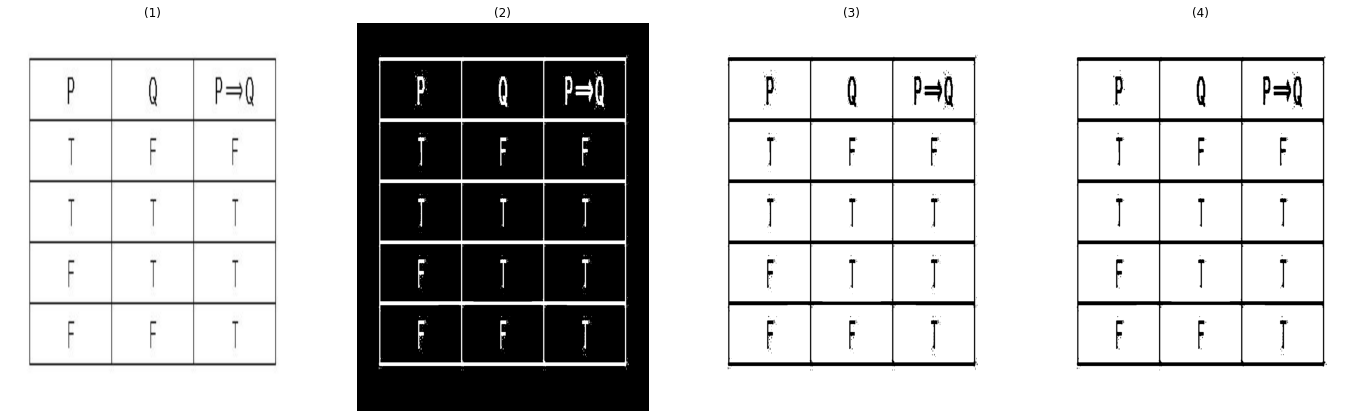

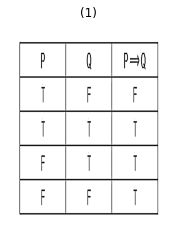

count rows 6


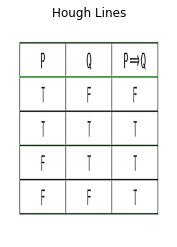

15
3 5


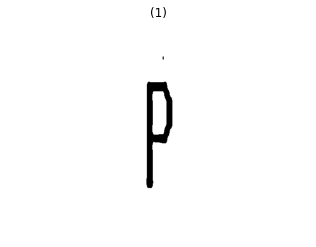

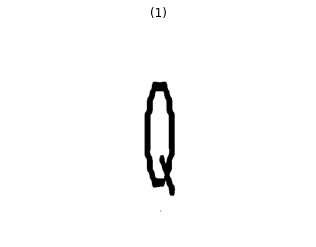

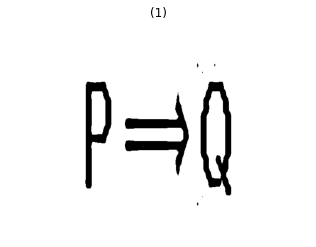

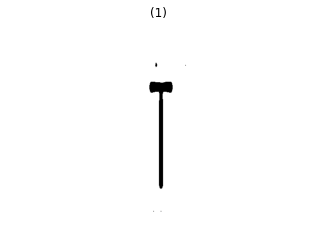

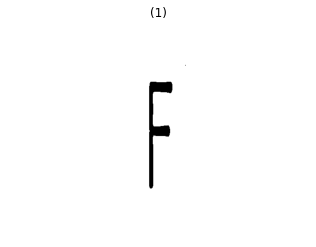

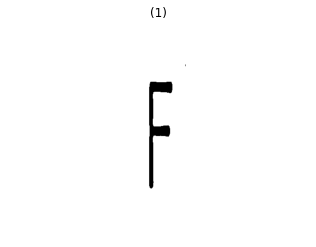

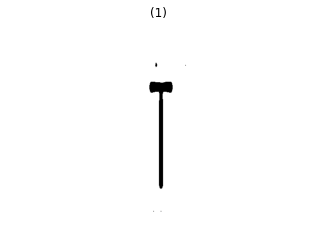

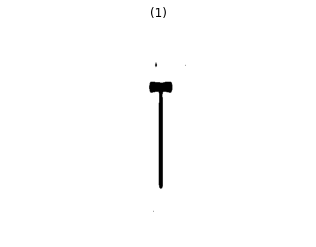

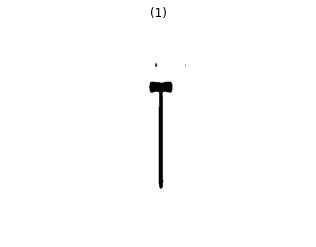

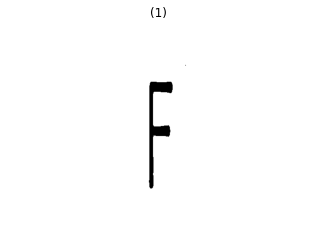

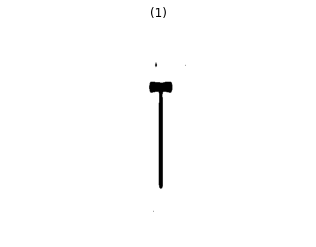

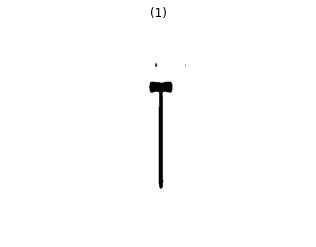

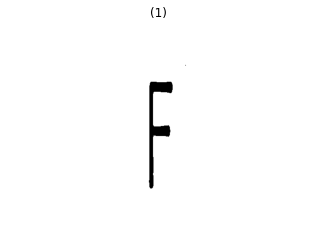

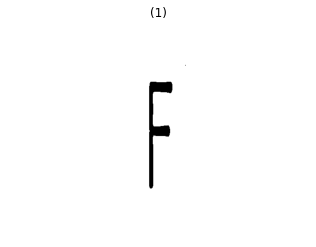

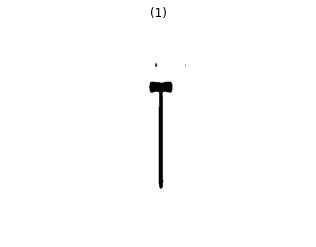

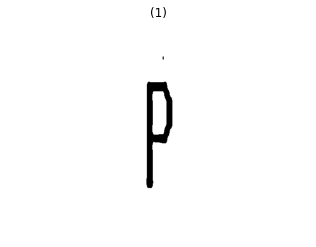

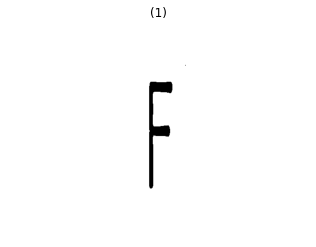

In [36]:
img = cv2.imread("table extraction/table_images/table4.jpg")
x = cells_extraction(img, True, False)